In [1]:
# InceptionV3 for Mammography Image Classification
# Organized Notebook for MIAS Dataset Analysis
# Authors: Fatih E. NAR , Sedat Kaymaz
#
# =========================================================================
# Section 1: Imports and Configuration
# =========================================================================

# Standard libraries
import os
import warnings
import time
import json
from glob import glob

# Data processing
import numpy as np
import pandas as pd
from tqdm import tqdm

# Image processing
import cv2
from PIL import Image
from skimage.io import imread

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, roc_auc_score, classification_report, 
    cohen_kappa_score, confusion_matrix
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

# Deep learning
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Flatten, BatchNormalization, Dense, 
    Activation, Dropout
)
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
)
from tensorflow.keras.utils import to_categorical
from livelossplot import PlotLossesKeras

# Suppress warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce TF logging

# Configure GPU settings
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

print("All modules have been imported")

# Set base directory
base_dir = './'
os.chdir(base_dir)

# Configure GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for all GPUs")
    except RuntimeError as e:
        print(f"Error in GPU config: {e}")

2025-03-01 01:07:19.017691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740791239.034989   11222 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740791239.040309   11222 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-01 01:07:19.057651: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


All modules have been imported
Memory growth enabled for all GPUs


In [2]:
# =========================================================================
# Section 2: Utility Functions
# =========================================================================

def clear_memory():
    """Free memory after finishing with the model"""
    tf.keras.backend.clear_session()
    import gc
    gc.collect()
    print("TensorFlow session cleared and Python garbage collected.")

class GompertzReLU(tf.keras.layers.Layer):
    """Custom activation function: Gompertz-ReLU"""
    def __init__(self, a=1.0, b=1.0, c=1.0):
        super(GompertzReLU, self).__init__()
        self.a = a
        self.b = b
        self.c = c

    def call(self, inputs):
        return tf.where(
            inputs >= 0, 
            inputs, 
            self.a * tf.exp(-self.b * tf.exp(-self.c * tf.abs(inputs)))
        )

def read_info_txt(file, bg_to_process, class_to_process):
    """
    Read and parse the MIAS database information file
    
    Parameters:
    file (str): Path to the info.txt file
    bg_to_process (list): List of background tissue types to include
    class_to_process (list): List of abnormality classes to include
    
    Returns:
    tuple: (DataFrame of mammogram info, Dictionary mapping image IDs to info)
    """
    print(f"Starting to read in file: {file}")
    rows = []
    mmi = {}
    
    with open(file, "r") as f:
        for line in f:
            line = line.strip()
            # Skip non-data lines
            if not line.startswith("mdb"):
                continue
            
            parts = line.split()
            
            # Prepare a dict for each row
            row_dict = {
                "REF": None,        # e.g. "mdb001"
                "BG": None,         # background tissue: F/G/D
                "CLASS": None,      # abnormality class: CALC/CIRC/SPIC/MISC/ARCH/ASYM/NORM
                "SEVERITY": None,   # B or M, if present
                "X": None,
                "Y": None,
                "RADIUS": None
            }
            
            # REF = the first item, e.g. "mdb001"
            row_dict["REF"] = parts[0]
            # BG (background tissue) = second item, e.g. "G"
            row_dict["BG"] = parts[1]
            # CLASS (abnormality) = third item, e.g. "CIRC" or "NORM"
            row_dict["CLASS"] = parts[2]

            # Filter by background tissue and class
            if row_dict["BG"] not in bg_to_process:
                continue
            if row_dict["CLASS"] not in class_to_process:
                continue
            
            # If there's exactly 3 parts, that means something like "mdb003 D NORM"
            if len(parts) == 3:
                rows.append(row_dict)
                mmi[row_dict["REF"]] = row_dict
                continue
            
            # If there's a 4th part, it's typically severity (B/M)
            row_dict["SEVERITY"] = parts[3]
            
            # Some lines might stop at 4 parts (e.g. "mdb059 F CIRC B")
            if len(parts) == 4:
                rows.append(row_dict)
                mmi[row_dict["REF"]] = row_dict
                continue
            
            # If we have at least 7 parts, we have x,y,radius
            if len(parts) >= 7:
                row_dict["X"] = parts[4]
                row_dict["Y"] = parts[5]
                row_dict["RADIUS"] = parts[6]
            
            mmi[row_dict["REF"]] = row_dict
            rows.append(row_dict)

    # Create the DataFrame
    pd_info = pd.DataFrame(rows)
    print(f"Read {len(rows)} valid entries from information file")
    return pd_info, mmi

def get_roi_coords(mmi, img):
    """
    Extract coordinates of region of interest from image info
    
    Parameters:
    mmi (dict): Dictionary mapping image IDs to info
    img (str): Image ID
    
    Returns:
    tuple: (class_label, severity, x, y, radius) for the image
    """
    if mmi[img]['CLASS'] == 'NORM':
        return mmi[img]['CLASS'], None, None, None, None
    elif mmi[img]['CLASS'] == 'CIRC':
        if mmi[img]['X'] is not None:
            severity = mmi[img]['SEVERITY']
            x = int(mmi[img]['X'])
            y = int(mmi[img]['Y'])
            radius = int(mmi[img]['RADIUS'])
            return mmi[img]['CLASS'], severity, x, y, radius
        else:
            severity = mmi[img]['SEVERITY']
            return mmi[img]['CLASS'], severity, None, None, None
    
    return None, None, None, None, None

def read_labels(mmi, no_angles, angle_interval):
    """
    Create labels for each image and its rotations
    
    Parameters:
    mmi (dict): Dictionary mapping image IDs to info
    no_angles (int): Maximum angle of rotation
    angle_interval (int): Interval between rotations
    
    Returns:
    dict: Dictionary mapping image IDs to angle-specific labels
    """
    print("Reading labels...")
    info = {}

    for key, value in mmi.items():
        img = key
        if mmi[img]['CLASS'] == 'NORM':
            info[img] = {angle: 2 for angle in range(0, no_angles, angle_interval)}  # Label "Normal" -> 2
        elif mmi[img]['SEVERITY'] == 'B':
            info[img] = {angle: 0 for angle in range(0, no_angles, angle_interval)}  # Label "Benign" -> 0
        elif mmi[img]['SEVERITY'] == 'M':
            info[img] = {angle: 1 for angle in range(0, no_angles, angle_interval)}  # Label "Malign" -> 1

    print(f'..The number of read labels: {len(mmi)}')
    return info

def read_rotate_flip_image3(mmi, url, no_angles, angle_interval):
    """
    Read, rotate, and flip images for data augmentation
    
    Parameters:
    mmi (dict): Dictionary mapping image IDs to info
    url (str): Base path to image files
    no_angles (int): Maximum angle of rotation
    angle_interval (int): Interval between rotations
    
    Returns:
    dict: Dictionary mapping image IDs to angle-specific augmented images
    """
    print("Reading, rotating, and flipping images...")
    info = {}
    
    for key, value in tqdm(mmi.items(), desc="Processing Images"):
        image_name = key
        image_address = url + image_name + '.pgm'
        
        class_label, severity, x_center, y_center, radius = get_roi_coords(mmi, image_name)
        
        img = cv2.imread(image_address, 1)
        if class_label == "CIRC" and x_center is not None and y_center is not None and radius is not None:
            # Crop the region of interest (ROI)
            x1 = max(x_center - radius, 0)
            y1 = max(y_center - radius, 0)
            x2 = min(x_center + radius, img.shape[1])
            y2 = min(y_center + radius, img.shape[0])
            roi = img[y1:y2, x1:x2]
            # Resize based on ROI
            img = cv2.resize(roi, (224, 224))
        else:
            # Just resize                
            img = cv2.resize(img, (224, 224))
      
        rows, cols, channel = img.shape
        info[image_name] = {}

        # Rotation + Flip
        for angle in range(0, no_angles, angle_interval):
            M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
            img_rotated = cv2.warpAffine(img, M, (cols, rows))
            img_flipped = cv2.flip(img_rotated, 1)
            info[image_name][angle] = img_flipped
            
    print(f'Total number of processed images: {len(mmi)}')
    return info

Starting to read in file: data/images/Info.txt
Read 232 valid entries from information file
Information file summary:
      REF BG CLASS SEVERITY     X     Y RADIUS
0  mdb001  G  CIRC        B   535   425    197
1  mdb002  G  CIRC        B   522   280     69
2  mdb003  D  NORM     None  None  None   None
3  mdb004  D  NORM     None  None  None   None
4  mdb005  F  CIRC        B   477   133     30
Reading labels...
..The number of read labels: 230
Reading, rotating, and flipping images...


Processing Images: 100%|██████████| 230/230 [00:04<00:00, 46.01it/s]


Total number of processed images: 230

Dataset Details:
Original Image count: 230, Labels: 230
After rotation/flip with 45 angles: X=10350, Y=10350
Training set: 7245 samples
Validation set: 2173 samples
Test set: 932 samples

Displaying sample images from training set:


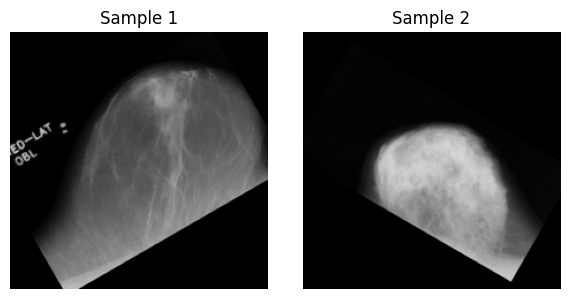

In [3]:
# =========================================================================
# Section 3: Data Preparation
# =========================================================================

# Configuration variables
bg_to_process = ['G', 'D', 'F']  # Background tissue types to include
class_to_process = ['CIRC', 'NORM']  # Abnormality classes to include
file_path = "data/images/Info.txt"  # Path to info file
url = 'data/images/'  # Path to image files

# Data augmentation parameters
no_angles = 360  # Maximum angle of rotation
angle_interval = 8  # Interval between rotations

# Get image information
info, mmi = read_info_txt(file_path, bg_to_process, class_to_process)
print("Information file summary:")
print(info.head())

# Get labels
label_info = read_labels(mmi, no_angles, angle_interval)

# Get augmented images
image_info = read_rotate_flip_image3(mmi, url, no_angles, angle_interval)

# Prepare data for model
ids = label_info.keys()

X = []
Y = []
for id in ids:
    for angle in range(0, no_angles, angle_interval):
        X.append(image_info[id][angle])
        Y.append(label_info[id][angle])

X = np.array(X)
Y = np.array(Y)
Y = to_categorical(Y, 3)  # Convert to one-hot encoding

# Split the data into training, validation, and test sets
x_train, x_test1, y_train, y_test1 = train_test_split(X, Y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test1, y_test1, test_size=0.3, random_state=42)

# Display dataset statistics
print("\nDataset Details:")
print(f"Original Image count: {len(image_info)}, Labels: {len(label_info)}")
print(f"After rotation/flip with {360//angle_interval} angles: X={len(X)}, Y={len(Y)}")
print(f"Training set: {len(x_train)} samples")
print(f"Validation set: {len(x_val)} samples")
print(f"Test set: {len(x_test)} samples")

# Display sample images
print("\nDisplaying sample images from training set:")
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
for i in range(2):
    axes[i].imshow(x_train[i].astype('uint8'))
    axes[i].set_title(f"Sample {i+1}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

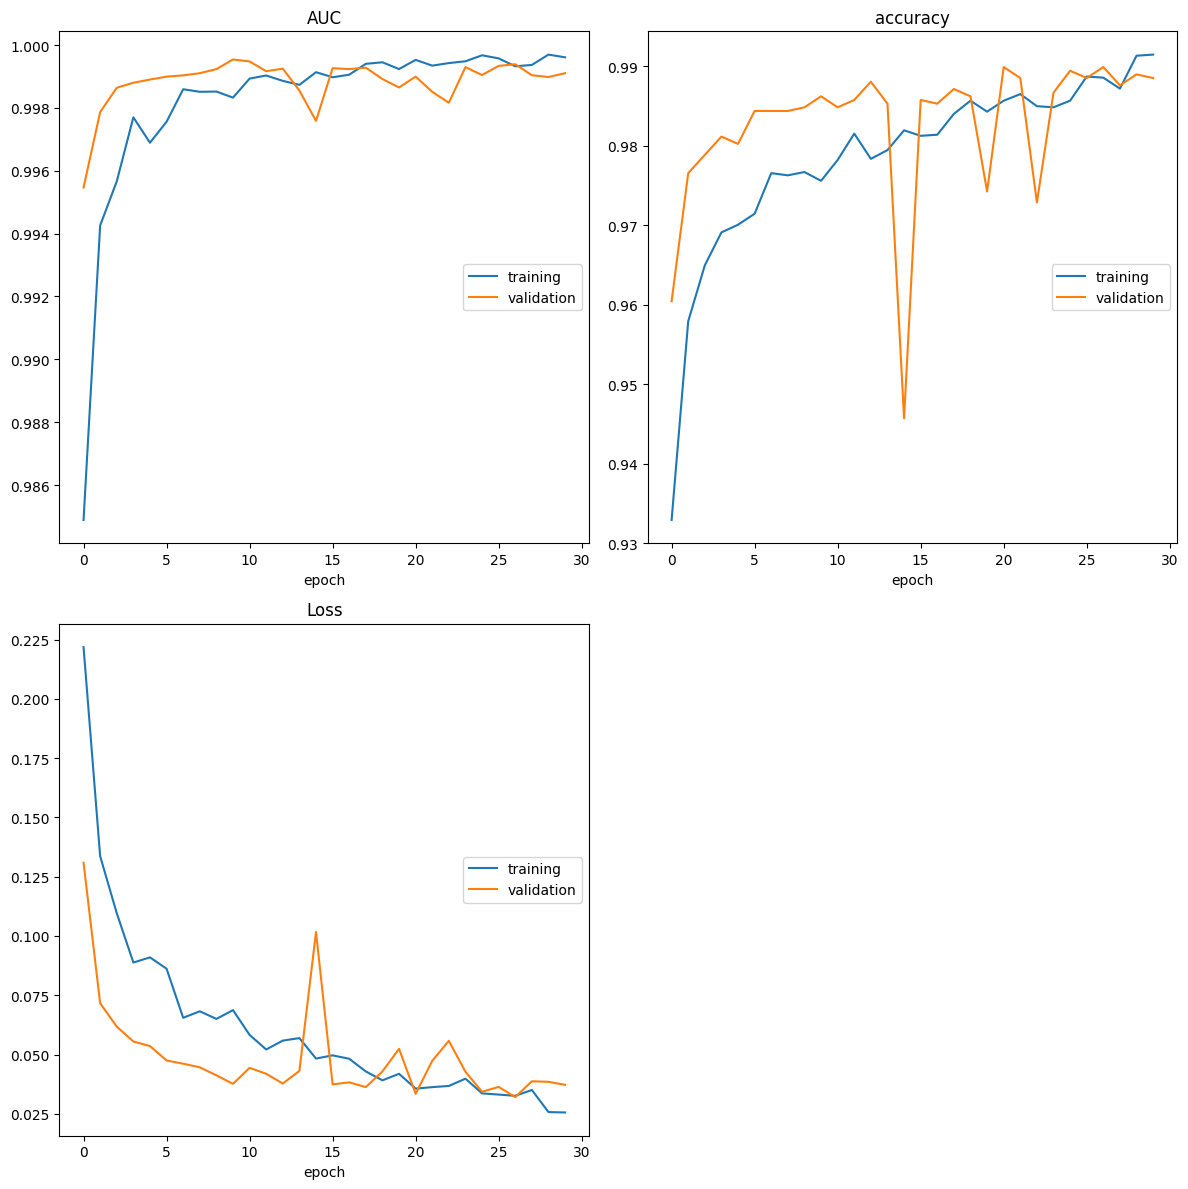

AUC
	training         	 (min:    0.985, max:    1.000, cur:    1.000)
	validation       	 (min:    0.995, max:    1.000, cur:    0.999)
accuracy
	training         	 (min:    0.933, max:    0.991, cur:    0.991)
	validation       	 (min:    0.946, max:    0.990, cur:    0.988)
Loss
	training         	 (min:    0.026, max:    0.222, cur:    0.026)
	validation       	 (min:    0.032, max:    0.131, cur:    0.037)

Epoch 30: val_loss did not improve from 0.03205
453/453 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - AUC: 0.9996 - accuracy: 0.9908 - loss: 0.0295 - val_AUC: 0.9991 - val_accuracy: 0.9885 - val_loss: 0.0372 - learning_rate: 0.0010


In [5]:
# =========================================================================
# Section 4: Model Definition and Training
# =========================================================================

# Define callbacks
plot_losses = PlotLossesKeras()

early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=6,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=6,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.001
)

# Define custom activation function
gompertzrelu_activation = GompertzReLU(a=1.0, b=1.0, c=1.0)

# Build the model
print("Building InceptionV3 model...")

# Load the InceptionV3 model without its final classification layer
base_neural_net = InceptionV3(
    input_shape=(224, 224, 3), 
    weights='imagenet', 
    include_top=False
)

# Freeze the base model's weights
for layer in base_neural_net.layers:
    layer.trainable = False

# Create the Sequential model
model = Sequential([
    base_neural_net,
    Flatten(),
    BatchNormalization(),
    Dense(256, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation(gompertzrelu_activation),  # Custom activation function
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes: Benign, Malignant, Normal
])

# Compile the model
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy', 'AUC']
)

# Model summary
model.summary()

# Define the checkpoint to save the best weights
checkpoint_filepath = 'best_weights.weights.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# Train the model
print("\nTraining model...")
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=30,
    batch_size=16,
    callbacks=[plot_losses, checkpoint_callback, early_stopping, reduce_lr]
)

In [6]:
# =========================================================================
# Section 5: Model Evaluation
# =========================================================================

# Evaluate on validation set
print("\nEvaluating model on validation set:")
val_results = model.evaluate(x_val, y_val, batch_size=16)
print(f"Validation Loss: {val_results[0]:.4f}")
print(f"Validation Accuracy: {val_results[1]:.4f}")
print(f"Validation AUC: {val_results[2]:.4f}")

# Generate predictions on test set
print("\nGenerating predictions on test set...")
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Performance metrics
print("\nPerformance Report:")
target_names = ["Benign", "Malignant", "Normal"]

print(f'Accuracy score: {accuracy_score(y_test_classes, y_pred):.4f}')
print(f'Precision score: {precision_score(y_test_classes, y_pred, average="weighted"):.4f}')
print(f'Recall score: {recall_score(y_test_classes, y_pred, average="weighted"):.4f}')
print(f'F1 Score: {f1_score(y_test_classes, y_pred, average="weighted"):.4f}')

# One-hot encode test labels for ROC analysis
y_test_bin = label_binarize(y_test_classes, classes=[0, 1, 2])

# Calculate ROC AUC for multiclass
roc_auc = roc_auc_score(y_test_bin, y_pred_probs, multi_class='ovo', average='weighted')
print(f'ROC AUC Score: {roc_auc:.4f}')

# Classification report
print('\nClassification Report:')
print(classification_report(y_test_classes, y_pred, target_names=target_names))
print(f'Cohen Kappa Score: {cohen_kappa_score(y_test_classes, y_pred):.4f}')

# Class distribution in test set
unique_classes, class_counts = np.unique(y_test_classes, return_counts=True)
print("\nClass distribution in test set:")
for cls, count in zip(unique_classes, class_counts):
    print(f"  Class {cls} ({target_names[cls]}): {count} samples")


Evaluating model on validation set:
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.9993 - accuracy: 0.9904 - loss: 0.0309
Validation Loss: 0.0321
Validation Accuracy: 0.9899
Validation AUC: 0.9994

Generating predictions on test set...
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step

Performance Report:
Accuracy score: 0.9850
Precision score: 0.9844
Recall score: 0.9850
F1 Score: 0.9828
ROC AUC Score: 0.9990

Classification Report:
              precision    recall  f1-score   support

      Benign       0.88      0.96      0.92        84
   Malignant       0.83      0.33      0.48        15
      Normal       1.00      1.00      1.00       833

    accuracy                           0.98       932
   macro avg       0.90      0.77      0.80       932
weighted avg       0.98      0.98      0.98       932

Cohen Kappa Score: 0.9214

Class distribution in test set:
  Class 0 (Benign): 84 samples
  Class 1 (Malignant): 15 samples
  Class 2 (Normal): 833 samples


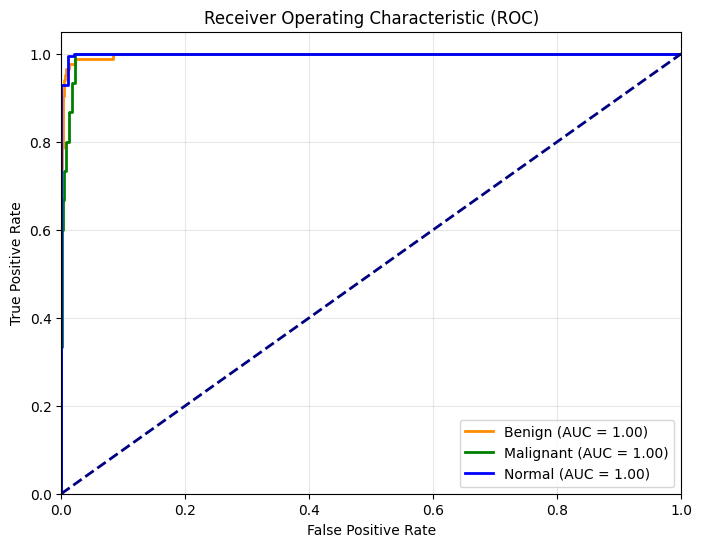

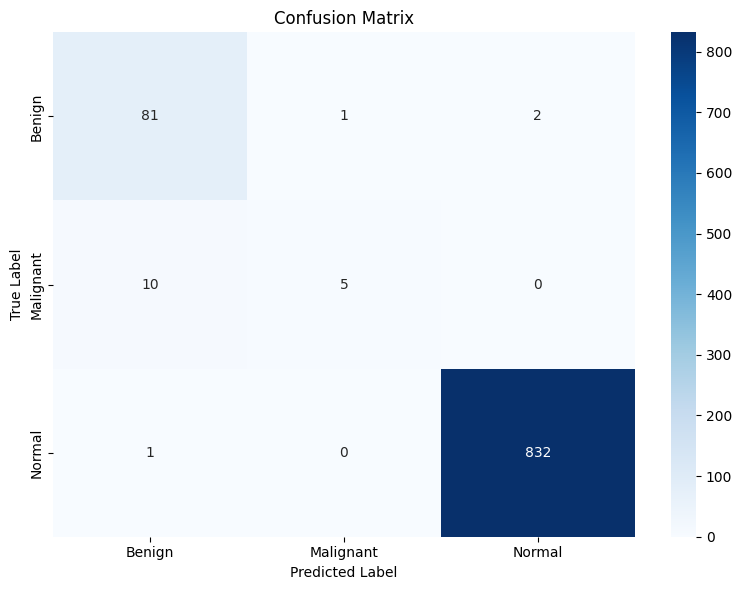

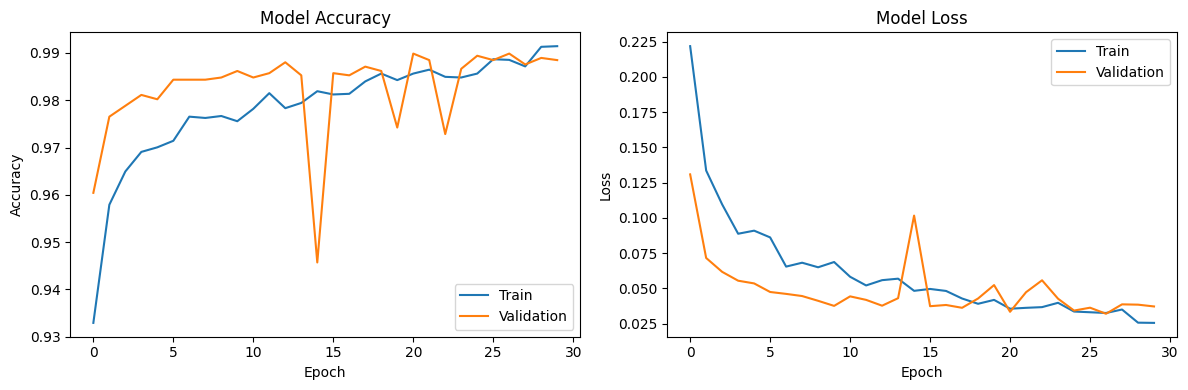

TensorFlow session cleared and Python garbage collected.
Notebook execution completed successfully. Cok Tesekkurler Dohtor Hanim


In [7]:
# =========================================================================
# Section 6: Visualization
# =========================================================================

# Plot ROC curves
fpr = {}
tpr = {}
thresholds = {}
roc_auc = {}

plt.figure(figsize=(8, 6))
colors = ['darkorange', 'green', 'blue']

for i, color, label in zip(range(3), colors, target_names):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label=f'{label} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Plot confusion matrix
cm = confusion_matrix(y_test_classes, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

# Clean up memory
model = None
clear_memory()
print("Notebook execution completed successfully. Cok Tesekkurler Dohtor Hanim")